# Compare logistic regression models of TP53 mutation for a) covariates only and b) covariates with gene expression data to determine marginal gain using gene expression data 

In [167]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.feature_selection import SelectKBest
from statsmodels.robust.scale import mad
from IPython.display import display
import gc

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Specify model configuration

In [3]:
# We're going to be building a 'TP53' classifier 
GENE = '7157' # TP53

*Here is some [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) regarding the classifier and hyperparameters*

*Here is some [information](https://ghr.nlm.nih.gov/gene/TP53) about TP53*

## Load Data

In [4]:
%%time
path = os.path.join('..', '..', 'download', 'covariates.tsv')
covariates = pd.read_table(path, index_col=0)
path = os.path.join('..', '..', 'download', 'expression-matrix.tsv.bz2')
expression = pd.read_table(path, index_col=0)

CPU times: user 3min 10s, sys: 4.13 s, total: 3min 14s
Wall time: 3min 15s


In [14]:
%%time
path = os.path.join('..','..','download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 1min 51s, sys: 6.25 s, total: 1min 58s
Wall time: 1min 59s


In [278]:
X = {}
X['a'] = covariates
X['b'] = pd.concat([covariates,expression], axis=1)
for k in ['a','b']:
    print(X[k].shape)

(7306, 70)
(7306, 20600)


In [147]:
# Which columns have NaN values? 
for k in ['a','b']:
    print(X[k].columns[pd.isnull(X[k]).any()].tolist())

['age_diagnosed', 'days_survived', 'days_recurrence_free']
['age_diagnosed', 'days_survived', 'days_recurrence_free']


In [159]:
y = Y[GENE]

In [160]:
# The Series now holds TP53 Mutation Status for each Sample
y.head(6)

sample_id
TCGA-02-0047-01    0
TCGA-02-0055-01    1
TCGA-02-2483-01    1
TCGA-02-2485-01    1
TCGA-02-2486-01    0
TCGA-04-1348-01    1
Name: 7157, dtype: int64

In [164]:
# Here are the percentage of tumors with NF1
y.value_counts(True)

,age_diagnosed,days_survived,days_recurrence_free,acronym_ACC,acronym_BLCA,acronym_BRCA,acronym_CESC,acronym_CHOL,acronym_COAD,acronym_DLBC,...,organ_Thymus,organ_Thyroid Gland,organ_Uterus,female,male,alive,dead,has_not_recurred,has_recurred,n_mutations_log1p
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047-01,78.0,448.0,NaN,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,3.6889
TCGA-02-0055-01,62.0,76.0,NaN,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,3.5264


## Set aside 10% of the data for testing

In [165]:
X_train = {}
X_test = {}
for k in ['a','b']:
    X_train[k], X_test[k], y_train, y_test = train_test_split(X[k], y, test_size=0.1, random_state=0)
    'Size: {:,} features, {:,} training samples, {:,} testing samples'.format(len(X[k].columns), 
                                                                              len(X_train[k]), len(X_test[k]))

## Median absolute deviation feature selection

In [20]:
def fs_mad(x, y):
    """    
    Get the median absolute deviation (MAD) for each column of x
    """
    scores = mad(x) 
    return scores, np.array([np.NaN]*len(scores))

## Define pipeline and Cross validation model fitting

In [22]:
# Parameter Sweep for Hyperparameters
param_grid = {
    'classify__loss': ['log'],
    'classify__penalty': ['elasticnet'],
    'classify__alpha': 10.0 ** np.linspace(-3, 1, 10),
    'classify__l1_ratio': [0.15],
}

pipeline = Pipeline(steps=[
    ('imputer', Imputer()),    
    ('select', SelectKBest(fs_mad)),
    ('standardize', StandardScaler()),
    ('classify', SGDClassifier(random_state=0, class_weight='balanced'))
])

cv_pipeline = {}
for k in ['a','b']:
    pg = param_grid.copy()
    if k == 'a': pg['select__k'] = ['all']
    elif k=='b': pg['select__k'] = [2000]
    cv_pipeline[k] =  GridSearchCV(estimator=pipeline, param_grid=pg, scoring='roc_auc')

In [62]:
%%time
# Train model a.
cv_pipeline['a'].fit(X=X_train['a'], y=y_train)

CPU times: user 7.34 s, sys: 250 ms, total: 7.59 s
Wall time: 3.94 s


In [23]:
%%time
# Train model b.
cv_pipeline['b'].fit(X=X_train['b'], y=y_train)

CPU times: user 9min 31s, sys: 7min 9s, total: 16min 41s
Wall time: 17min 52s


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('select', SelectKBest(k=10, score_func=<function fs_mad at 0x160babe18>)), ('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classify', SGDClassifier(alpha=0.0001, average=Fa...      penalty='l2', power_t=0.5, random_state=0, shuffle=True, verbose=0,
       warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'classify__l1_ratio': [0, 0.2, 0.8, 1], 'select__k': [2000], 'classify__alpha': [0.001, 0.01, 0.1, 1], 'classify__penalty': ['elasticnet'], 'classify__loss': ['log']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [168]:
# Best Params
for k in ['a','b']:
    print('{:.3%}'.format(cv_pipeline[k].best_score_))
    print(cv_pipeline[k].best_params_)

84.301%
{'classify__l1_ratio': 0.2, 'classify__loss': 'log', 'classify__alpha': 0.01, 'select__k': 'all', 'classify__penalty': 'elasticnet'}
91.720%
{'classify__l1_ratio': 0, 'classify__loss': 'log', 'classify__alpha': 0.1, 'select__k': 2000, 'classify__penalty': 'elasticnet'}


## Visualize hyperparameters performance

In [169]:
cv_result_df = {}
for k in ['a','b']:
    cv_result_df[k] = pd.concat([
        pd.DataFrame(cv_pipeline[k].cv_results_),
        pd.DataFrame.from_records(cv_pipeline[k].cv_results_['params']),
    ], axis='columns')
    display(cv_result_df[k].head(2))

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_classify__alpha,param_classify__l1_ratio,param_classify__loss,param_classify__penalty,param_select__k,params,...,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score,classify__alpha,classify__l1_ratio,classify__loss,classify__penalty,select__k
0,0.058835,0.006842,0.796490,0.805045,0.001,0,log,elasticnet,all,"{'classify__l1_ratio': 0, 'classify__loss': 'l...",...,0.813876,0.005618,0.001079,0.013865,0.006263,0.001,0.0,log,elasticnet,all
1,0.061259,0.006238,0.815005,0.822837,0.001,0.2,log,elasticnet,all,"{'classify__l1_ratio': 0.2, 'classify__loss': ...",...,0.815809,0.001769,0.000064,0.003304,0.007461,0.001,0.2,log,elasticnet,all


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_classify__alpha,param_classify__l1_ratio,param_classify__loss,param_classify__penalty,param_select__k,params,...,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score,classify__alpha,classify__l1_ratio,classify__loss,classify__penalty,select__k
0,30.052915,2.269723,0.889301,0.949550,0.001,0,log,elasticnet,2000,"{'classify__l1_ratio': 0, 'classify__loss': 'l...",...,0.958830,10.741624,0.514205,0.004930,0.006647,0.001,0.0,log,elasticnet,2000
1,18.093606,1.848320,0.899862,0.964644,0.001,0.2,log,elasticnet,2000,"{'classify__l1_ratio': 0.2, 'classify__loss': ...",...,0.963184,1.701577,0.012262,0.002121,0.001391,0.001,0.2,log,elasticnet,2000


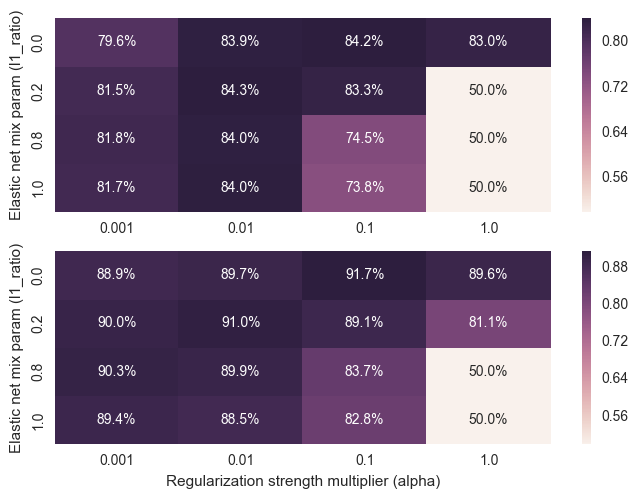

In [170]:
# Cross-validated performance heatmap
for i,k in enumerate(['a','b']):
    ax = plt.subplot(2,1,i+1)
    cv_score_mat = pd.pivot_table(cv_result_df[k], values='mean_test_score', index='classify__l1_ratio', columns='classify__alpha')

    ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
    if i == 1: ax.set_xlabel('Regularization strength multiplier (alpha)')
    else: ax.set_xlabel('')
    ax.set_ylabel('Elastic net mix param (l1_ratio)');

## Use Optimal Hyperparameters to Output ROC Curve

In [180]:
def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

y_pred_train = {}
y_pred_test = {}
metrics_train = {}
metrics_test = {}
for k in ['a','b']:
    y_pred_train[k] = cv_pipeline[k].decision_function(X_train[k])
    y_pred_test[k] = cv_pipeline[k].decision_function(X_test[k])

    metrics_train[k] = get_threshold_metrics(y_train, y_pred_train[k])
    metrics_test[k] = get_threshold_metrics(y_test, y_pred_test[k])

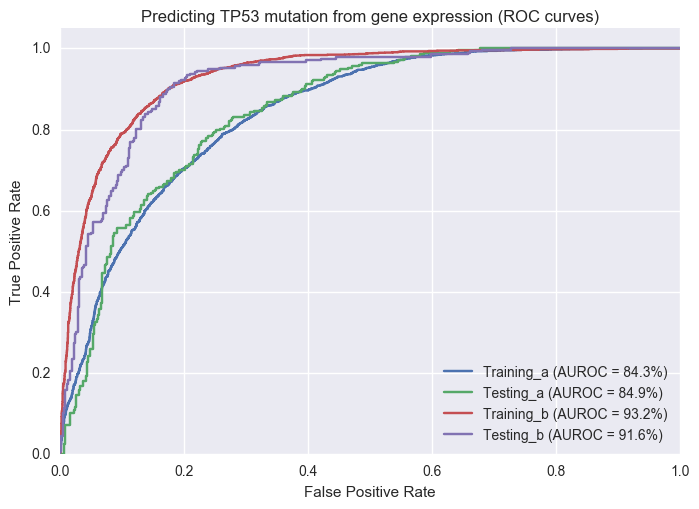

In [186]:
# Plot ROC
for i,k in enumerate(['a','b']):
    for label, metrics in ('Training', metrics_train[k]), ('Testing', metrics_test[k]):
        roc_df = metrics['roc_df']
        plt.plot(roc_df.fpr, roc_df.tpr,
            label='{} (AUROC = {:.1%})'.format(label+'_'+str(k), metrics['auroc']))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Predicting TP53 mutation from gene expression (ROC curves)')
    plt.legend(loc='lower right');

## What are the classifier coefficients?

In [188]:
final_pipeline = {}
final_classifier = {}
for k in ['a','b']:
    final_pipeline[k] = cv_pipeline[k].best_estimator_
    final_classifier[k] = final_pipeline[k].named_steps['classify']

In [194]:
coef_df = {}
for k in ['a','b']:
    select_indices = final_pipeline[k].named_steps['select'].transform(
        np.arange(len(X[k].columns)).reshape(1, -1)
    ).tolist()

    coef_df[k] = pd.DataFrame.from_items([
        ('feature', X[k].columns[select_indices]),
        ('weight', final_classifier[k].coef_[0]),
    ])

    coef_df[k]['abs'] = coef_df[k]['weight'].abs()
    coef_df[k] = coef_df[k].sort_values('abs', ascending=False)

In [196]:
for k in ['a','b']:
    print('{:.1%} zero coefficients; {:,} negative and {:,} positive coefficients'.format(
            (coef_df[k].weight == 0).mean(),
            (coef_df[k].weight < 0).sum(),
            (coef_df[k].weight > 0).sum()
    ))

20.0% zero coefficients; 28 negative and 28 positive coefficients
0.0% zero coefficients; 943 negative and 1,057 positive coefficients


In [263]:
# What are the top weighted features for model a and model b?
display(coef_df['b'].head(5))
display(coef_df['a'].head(5))

,feature,weight,abs,isFeatureFromA
1352,60401,-0.449393,0.449393,False
905,9518,-0.181251,0.181251,False
1227,55065,-0.159131,0.159131,False
124,1029,0.157195,0.157195,False
1286,56164,0.120941,0.120941,False


,feature,weight,abs
69,n_mutations_log1p,0.684084,0.684084
61,organ_Thyroid Gland,-0.308982,0.308982
30,acronym_THCA,-0.308982,0.308982
14,acronym_KIRC,-0.226078,0.226078
46,organ_Kidney,-0.208665,0.208665


In [265]:
# What are the model a features in model b?
def RepresentsInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

coef_df['b']['isFeatureFromA'] = [not RepresentsInt(x) for x in coef_df['b']['feature']]
display(coef_df['b'].query('isFeatureFromA'))
print('rank of model a features in model b:', np.flatnonzero(coef_df['b']['isFeatureFromA']))

,feature,weight,abs,isFeatureFromA
0,age_diagnosed,0.034247,0.034247,True
1,days_survived,0.014578,0.014578,True
2,days_recurrence_free,0.001559,0.001559,True


rank of model a features in model b: [ 647 1344 1926]


## Investigate the predictions

In [268]:
predict_df = {}
for k in ['a','b']:
    predict_df[k] = pd.DataFrame.from_items([
        ('sample_id', X[k].index),
        ('testing', X[k].index.isin(X_test[k].index).astype(int)),
        ('status', y),
        ('decision_function', cv_pipeline[k].decision_function(X[k])),
        ('probability', cv_pipeline[k].predict_proba(X[k])[:, 1]),
    ])
    predict_df[k]['probability_str'] = predict_df[k]['probability'].apply('{:.1%}'.format)

In [269]:
# Top predictions amongst negatives (potential hidden responders)
for k in ['a','b']:
    display(predict_df[k].sort_values('decision_function', ascending=False).query("status == 0").head(5))

,sample_id,testing,status,decision_function,probability,probability_str
sample_id,,,,,,
TCGA-IB-7651-01,TCGA-IB-7651-01,0,0,5.044342,0.993596,99.4%
TCGA-L5-A4OI-01,TCGA-L5-A4OI-01,1,0,3.889747,0.979959,98.0%
TCGA-L5-A8NM-01,TCGA-L5-A8NM-01,0,0,3.714916,0.976222,97.6%
TCGA-N7-A4Y0-01,TCGA-N7-A4Y0-01,0,0,3.321973,0.965175,96.5%
TCGA-CA-6717-01,TCGA-CA-6717-01,1,0,2.885321,0.947116,94.7%


,sample_id,testing,status,decision_function,probability,probability_str
sample_id,,,,,,
TCGA-L5-A4OH-01,TCGA-L5-A4OH-01,0,0,4.922734,0.992773,99.3%
TCGA-L5-A8NR-01,TCGA-L5-A8NR-01,0,0,4.885036,0.992498,99.2%
TCGA-09-2051-01,TCGA-09-2051-01,0,0,4.870500,0.992389,99.2%
TCGA-B6-A0I6-01,TCGA-B6-A0I6-01,1,0,4.567853,0.989726,99.0%
TCGA-55-6981-01,TCGA-55-6981-01,0,0,4.275788,0.986289,98.6%


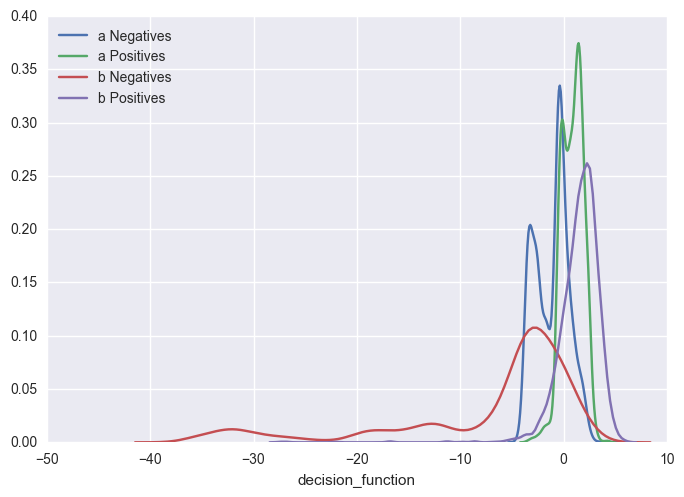

In [276]:
# Ignore numpy warning caused by seaborn
warnings.filterwarnings('ignore', 'using a non-integer number instead of an integer')
for k in ['a','b']:
    ax = sns.distplot(predict_df[k].query("status == 0").decision_function, hist=False, label=k+' Negatives')
    ax = sns.distplot(predict_df[k].query("status == 1").decision_function, hist=False, label=k+' Positives')

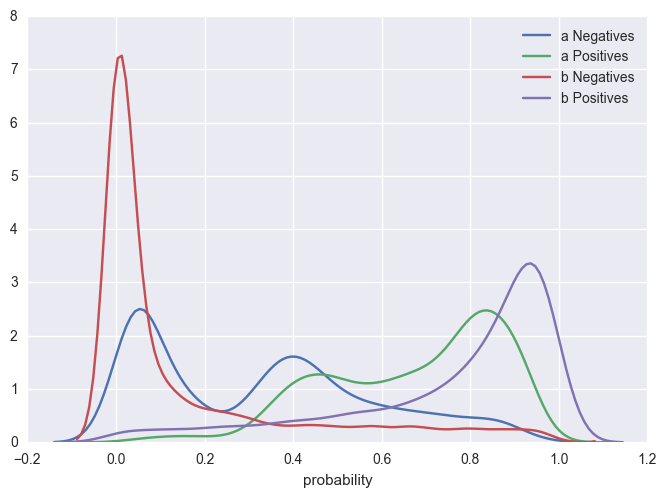

In [277]:
for k in ['a','b']:
    ax = sns.distplot(predict_df[k].query("status == 0").probability, hist=False, label=k+' Negatives')
    ax = sns.distplot(predict_df[k].query("status == 1").probability, hist=False, label=k+' Positives')